In [1]:
import csv
import numpy as np
import pandas as pd

Take a stock, find what cluster it is in

In [2]:
df = pd.read_csv('sp500_tickers_full_info.csv')

In [3]:
numeric_columns = df.select_dtypes(include=['number'])

In [4]:
df_numeric = df[['Ticker','sector']].join(df.select_dtypes(include=['number']))

In [5]:
# Check for infinity or NaN values
df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)
# Select only numeric columns and fill NaNs with their mean
numeric_cols = df_numeric.select_dtypes(include=["number"])
df_numeric[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

In [6]:
# Create a correlation matrix
numeric_features = df_numeric.drop(columns=["Ticker", "sector"])
correlation_matrix = numeric_features.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.85 (adjust threshold as needed)
high_correlation_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)
]

# Drop highly correlated features
numeric_features_reduced = numeric_features.drop(columns=high_correlation_features)
print(f"Reduced features from {numeric_features.shape[1]} to {numeric_features_reduced.shape[1]}")


Reduced features from 101 to 60


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features_reduced)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=25, init="k-means++", random_state=42)
df_numeric["Cluster"] = kmeans.fit_predict(scaled_features)


In [8]:
df_numeric_with_cluster = df[["Ticker", "sector"]].join(df_numeric[["Cluster"]])
df_numeric_with_cluster.head()

,Ticker,sector,Cluster
0,MMM,Industrials,5
1,AOS,Industrials,17
2,ABT,Healthcare,5
3,ABBV,Healthcare,7
4,ACN,Technology,11


In [9]:
# Compute and sort cluster distribution
cluster_distribution = df_numeric_with_cluster["Cluster"].value_counts().sort_values(ascending=False)
cluster_distribution

1     94
0     85
7     69
11    58
5     51
17    45
2     17
22    17
19    14
18    11
24    11
14     8
6      5
21     4
13     3
3      2
10     1
15     1
12     1
4      1
20     1
9      1
8      1
23     1
16     1
Name: Cluster, dtype: int64

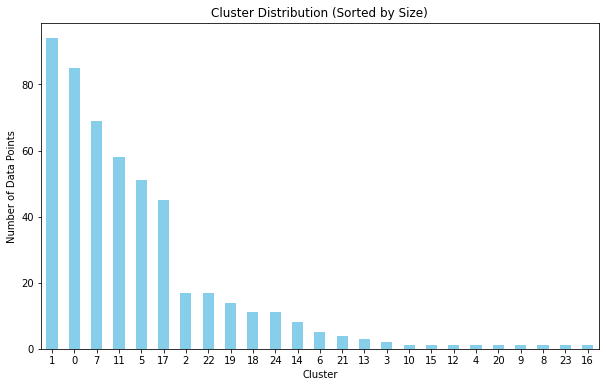

In [10]:
import matplotlib.pyplot as plt

# Plot cluster distribution (sorted)
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind="bar", color="skyblue")
plt.title("Cluster Distribution (Sorted by Size)")
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.xticks(rotation=0)
plt.show()


In [164]:
selected_features = [
    "marketCap", "priceToSalesTrailing12Months", "priceToBook", "returnOnAssets",
    "returnOnEquity", "grossMargins", "operatingMargins", "profitMargins", "currentRatio",
    "quickRatio", "totalRevenue", "revenueGrowth", "freeCashflow", "operatingCashflow",
    "debtToEquity", "earningsQuarterlyGrowth", "trailingPE", "forwardPE", "dividendYield", "beta"
]

# Subset the DataFrame
clustering_data = numeric_features[selected_features]

In [167]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data)
# Fit K-Means clustering
kmeans = KMeans(n_clusters=50, init="k-means++", random_state=42)
df_numeric_with_cluster["Cluster"] = kmeans.fit_predict(scaled_features)

# Check the cluster distribution
print(df_numeric_with_cluster["Cluster"].value_counts())

28    70
47    47
33    44
3     42
20    29
1     26
0     25
16    20
32    20
26    17
39    15
9     15
31    13
41    11
7     11
11     9
44     8
15     7
24     7
35     7
30     6
46     6
2      5
36     4
6      4
14     3
48     2
29     2
5      2
12     2
27     2
25     2
40     2
34     2
23     1
43     1
19     1
49     1
17     1
42     1
8      1
38     1
4      1
13     1
37     1
45     1
10     1
18     1
22     1
21     1
Name: Cluster, dtype: int64
